<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/Cat_vs_Dog_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
from google.colab import files

Mounted at /gdrive


In [1]:
#packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time

In [ ]:
data_zip_dir = '/content/drive/MyDrive'
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test1.zip')
 
with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall()

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive')
test_dir = os.path.join('/content/drive/MyDrive')
 
train_set_dir = os.path.join(train_dir, 'train1')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid1')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test1')
os.mkdir(test_set_dir)
 
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]


In [2]:
train_dir = os.path.join('/content/drive/MyDrive')
test_dir = os.path.join('/content/drive/MyDrive')
train_set_dir = os.path.join(train_dir, 'train1')
valid_set_dir = os.path.join(train_dir, 'valid1')
test_set_dir = os.path.join(train_dir, 'test1')

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [ ]:
for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir+'/train', dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir+'/train', cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir+'/train', dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir+'/train', cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir+'/train', dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir+'/train', cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)

In [3]:
#Data Generator

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]


In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])
#resize : 256 256 사이즈 변환
#RandomCrop : Zoom효과
#RandomHorizontalFlip : 랜덤 좌우반전
#ToTensor() : np를 torch.FloatTensor로 변환하고 0~255를 0~1로 변환

In [5]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

#label 별 dataset 생성

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


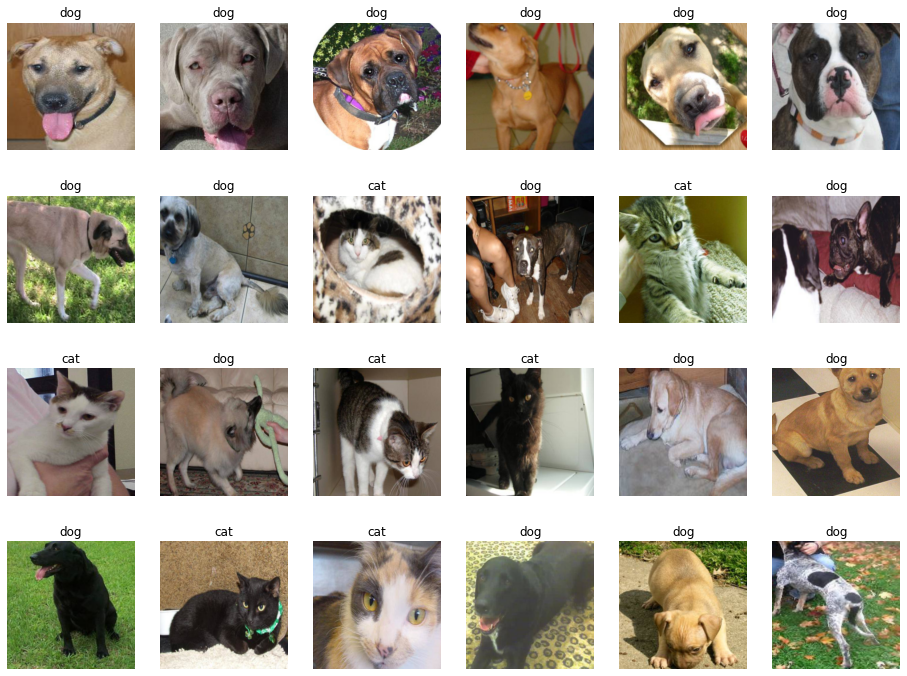

In [8]:
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [9]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# define model network 이거 왜 안되냐 ㅡㅡ
class AlexNet(nn.Module) :
    def __init__(self) -> None :
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),)
        
    def forward(self, x :torch.Tensor) -> torch.Tensor :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
model = torchvision.models.resnet50(pretrained=True)
#model = AlexNet()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs,1024),
    nn.Dropout(0.2),
    nn.Linear(1024,512),
    nn.Dropout(0.1),
    nn.Linear(512,1),
    nn.Sigmoid()

)

In [18]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
criterion = nn.BCELoss()

In [19]:
from torchsummary import summary
model.cuda()
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cuda()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cuda()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cuda()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cuda()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

In [ ]:
fit(model, criterion, optimizer,2, train_loader, valid_loader)